## Ethereum Stock Prices

* Import data
    * Show prices, market capital and volume
    * Analysis
* Preprocessing data
    * Complete the Index
    * Find NaN and Fix it
    * Closed Price Column
    * Normalizing
* Split data into training and test datasets
* Build the model
* Test the model
* Conclusions

### Import Libraries

In [1]:
import random
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

### Import Data and Analysis

In [2]:
data = pd.read_csv('eth-eur.csv')
data.iloc[random.randint(0, data.shape[0])]

snapped_at      2015-12-26 00:00:00 UTC
price                          0.777434
market_cap                  5.89102e+07
total_volume                     386543
Name: 140, dtype: object

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896 entries, 0 to 895
Data columns (total 4 columns):
snapped_at      896 non-null object
price           896 non-null float64
market_cap      895 non-null float64
total_volume    896 non-null float64
dtypes: float64(3), object(1)
memory usage: 28.1+ KB


In [4]:
#customize index
data.snapped_at[0].split()[0]
data.snapped_at = data.snapped_at.apply(lambda x: x.split()[0])

In [5]:
data.set_index('snapped_at', inplace=True)
data.index = pd.to_datetime(data.index)

In [6]:
features = ['price', 'market_cap', 'total_volume']

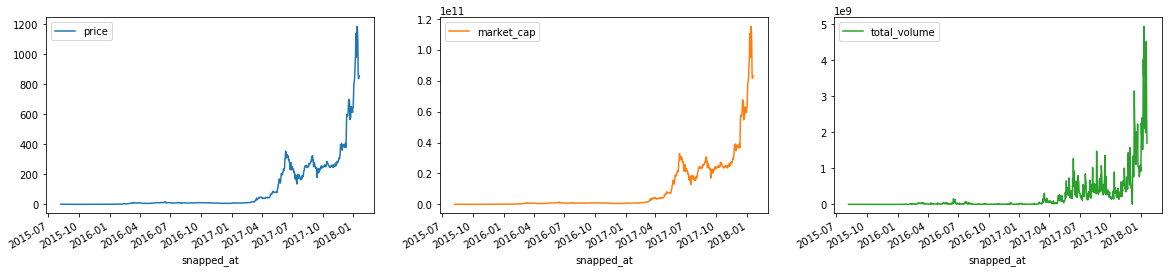

In [7]:
data[features].plot(subplots=True, layout=(1,3), figsize=(20,4));

In [8]:
data.head(24)

,price,market_cap,total_volume
snapped_at,,,
2015-08-07,2.580213,0.000000e+00,8.257608e+04
2015-08-08,1.175306,7.095505e+07,3.250759e+05
2015-08-10,0.624116,3.772033e+07,3.634980e+05
2015-08-11,0.966607,5.844581e+07,1.375588e+06
2015-08-12,1.126292,6.813006e+07,1.858814e+06
2015-08-13,1.636673,9.904778e+07,3.927292e+06
2015-08-14,1.643557,9.951063e+07,3.920484e+06
2015-08-15,1.505036,9.116528e+07,2.269451e+06
2015-08-16,1.329391,8.055977e+07,2.730304e+06


### Preprocessing Data

#### Complete the Index

The list is not complete _(2015-08-09 is missing)_ so we have to fill the blanks.

In [9]:
#check
'2015-08-09 00:00:00' in data.index

False

In [10]:
#Generate all the possible days and use them to reindex
start = data.index[data.index.argmin()]
end = data.index[data.index.argmax()]

index_complete = pd.date_range(start, end)
data = data.reindex(index_complete)

#### Find NaN and Fix it

In [11]:
#Fill the blanks with the mean between the previous and the day after

for idx in data.index:
    dayloc = data.index.get_loc(idx)
    day = data.loc[idx]
    if day.hasnans:
        #updating
        rg = slice(dayloc-1, dayloc+2)
        data.loc[idx] = data.iloc[rg].mean()
        
        print("Day <{}> updated".format(idx))

Day <2015-08-09 00:00:00> updated
Day <2017-04-02 00:00:00> updated


In [12]:
#check
data.loc['2015-08-09 00:00:00']

price           8.997108e-01
market_cap      5.433769e+07
total_volume    3.442869e+05
Name: 2015-08-09 00:00:00, dtype: float64

In [13]:
#Checking if we have NaN in another place
data[data.isnull().any(axis=1)].count()

price           0
market_cap      0
total_volume    0
dtype: int64

#### Closed Price Column

In [14]:
new_column = 'closed_price'
datab = data.copy()

nc = list()

for idx in data.index:
    dayloc = data.index.get_loc(idx)
    
    #we put the price in the day after as closed price
    if dayloc == len(data.index)-1:
        #last position will not have closed_price
        closed_price = np.nan
    else:
        closed_price = data.iloc[dayloc+1].price
    
    nc.append(closed_price)

data[new_column] = nc
data.tail(5)

,price,market_cap,total_volume,closed_price
2018-01-15,1084.204749,1.051702e+11,1.988101e+09,871.038635
2018-01-16,871.038635,8.450991e+10,4.236883e+09,838.829188
2018-01-17,838.829188,8.140486e+10,4.516756e+09,846.823344
2018-01-18,846.823344,8.219815e+10,2.632209e+09,856.639434
2018-01-19,856.639434,8.316864e+10,1.691466e+09,NaN


#### Normalizing

In [15]:
#Scale the data
scaler = StandardScaler()

data[features] = scaler.fit_transform(data[features])
data.describe()

,price,market_cap,total_volume,closed_price
count,8.970000e+02,8.970000e+02,8.970000e+02,896.000000
mean,-3.168529e-17,6.337059e-17,-6.337059e-17,101.637873
std,1.000558e+00,1.000558e+00,1.000558e+00,184.025144
min,-5.501562e-01,-5.415878e-01,-4.110179e-01,0.381455
25%,-5.135045e-01,-5.077948e-01,-4.031238e-01,7.150372
50%,-4.943143e-01,-4.909240e-01,-3.822954e-01,10.664045
75%,3.991864e-01,3.770718e-01,-1.335186e-02,175.193903
max,5.904563e+00,5.955011e+00,9.357096e+00,1187.079009


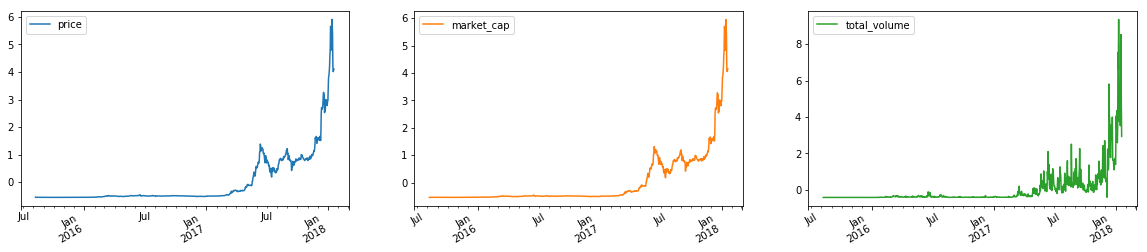

In [16]:
data[features].plot(subplots=True, layout=(1,3), figsize=(20,4));

### Split Data into Training and Test Datasets

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data[features], 
                                                    data.closed_price, 
                                                    test_size=0.20,
                                                    shuffle=False,
                                                    random_state=42)

In [18]:
print("Size X_train: {}".format(X_train.shape[0]))
print("Size X_test: {}".format(X_test.shape[0]))

Size X_train: 717
Size X_test: 180


## Check Tensorflow and GPU

In [19]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer'
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/samuel/anaconda/envs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:11: UserWarning: No GPU found. Please use a GPU to train your neural network.
  # This is added back by InteractiveShellApp.init_path()


## Build the Model

In [20]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler

#TODO!!
y_train.fillna(y_train.mean(), inplace=True)
print("NaN in y_train? : {}".format( y_train.isnull().any() ))

#X_train_prep = np.expand_dims(X_train, 2)
X_train_prep = X_train.values.reshape([X_train.shape[0], X_train.shape[1], 1])
y_train_prep = y_train.values

print(X_train_prep.shape)
print(X_train.iloc[0].tolist())

model = Sequential()
model.add(LSTM(128, input_shape=(3,1) ))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_prep, y_train_prep, epochs=150, batch_size=16, verbose=1)


Using TensorFlow backend.


NaN in y_train? : False
(717, 3, 1)
[-0.5381966110680989, -0.5415878272643443, -0.4110061503111665]
Epoch 1/150
717/717 [==============================] - 1s 1ms/step - loss: 5355.7309
Epoch 2/150
717/717 [==============================] - 1s 1ms/step - loss: 4948.4910
Epoch 3/150
717/717 [==============================] - 1s 1ms/step - loss: 4211.6395
Epoch 4/150
717/717 [==============================] - 1s 1ms/step - loss: 3923.0409
Epoch 5/150
717/717 [==============================] - 1s 1ms/step - loss: 3662.2638
Epoch 6/150
717/717 [==============================] - 1s 1ms/step - loss: 3436.3625
Epoch 7/150
717/717 [==============================] - 1s 1ms/step - loss: 3237.9954
Epoch 8/150
717/717 [==============================] - 1s 1ms/step - loss: 3070.0387
Epoch 9/150
717/717 [==============================] - 1s 992us/step - loss: 2921.5718
Epoch 10/150
717/717 [==============================] - 1s 1ms/step - loss: 2786.9137
Epoch 11/150
717/717 [=========================

717/717 [==============================] - 1s 983us/step - loss: 100.3275
Epoch 96/150
717/717 [==============================] - 1s 1ms/step - loss: 97.6256
Epoch 97/150
717/717 [==============================] - 1s 1ms/step - loss: 93.8319
Epoch 98/150
717/717 [==============================] - 1s 1ms/step - loss: 91.1419
Epoch 99/150
717/717 [==============================] - 1s 1ms/step - loss: 88.8565
Epoch 100/150
717/717 [==============================] - 1s 1ms/step - loss: 85.5354
Epoch 101/150
717/717 [==============================] - 1s 1ms/step - loss: 82.7953
Epoch 102/150
717/717 [==============================] - 1s 1ms/step - loss: 87.3998
Epoch 103/150
717/717 [==============================] - 1s 1ms/step - loss: 81.6535
Epoch 104/150
717/717 [==============================] - 1s 1ms/step - loss: 80.2640
Epoch 105/150
717/717 [==============================] - 1s 1ms/step - loss: 79.2277
Epoch 106/150
717/717 [==============================] - 1s 1ms/step - loss: 80.

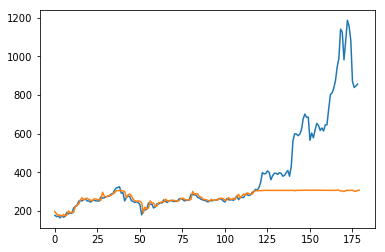

In [21]:
X_test_prep = X_test.values.reshape([X_test.shape[0], X_test.shape[1], 1])
y_test_prep = y_test.values

pred = model.predict(X_test_prep)
plt.plot(y_test.values)
plt.plot(pred)

The neural network is not able to get good predictions for data it has not seen before. For that reason we found the last fifty days are almost a horizontal line like it was there a threshold. This problem is related to 'out-of-scale' data inputs.

Thinking that the batch size is a window of days that defines how the neural network learns, one idea is to normalize the window by the last sample. On this way we'll be able to keep almost all data in the same scale.

In [103]:
window_size=32

def window_normalization(data, window_size):
    y = np.empty_like(data)
    for i in range(0,len(data), window_size):
        j = min(i+window_size, len(data)-1)
        #print(data[i:j,:].shape)
        #print(data[i:j,:].max(axis=1).shape)
        y[i:j] = data[i:j]/data[i:j].max(axis=0)

    return y

In [100]:
X_train_prep[0:2]

array([[[-0.53819661],
        [-0.54158783],
        [-0.41100615]],

       [[-0.54583823],
        [-0.53758299],
        [-0.41052614]]])

In [102]:
X_train_prep[0:2].max(axis=0)

array([[-0.53819661],
       [-0.53758299],
       [-0.41052614]])

In [101]:
X_train_prep[0:2]/X_train_prep[0:2].max(axis=0)

array([[[ 1.        ],
        [ 1.00744971],
        [ 1.00116926]],

       [[ 1.01419856],
        [ 1.        ],
        [ 1.        ]]])

In [104]:
X_train_norm = window_normalization(X_train_prep, window_size)
y_train_norm = window_normalization(y_train_prep, window_size)

model = Sequential()
model.add(LSTM(128, input_shape=(3,1) ))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_norm, y_train_norm, epochs=150, batch_size=window_size, verbose=1)


Epoch 1/150
717/717 [==============================] - 1s 1ms/step - loss: 0.2347
Epoch 2/150
717/717 [==============================] - 0s 573us/step - loss: 0.0764
Epoch 3/150
717/717 [==============================] - 0s 614us/step - loss: 0.0549
Epoch 4/150
717/717 [==============================] - 0s 609us/step - loss: 0.0487
Epoch 5/150
717/717 [==============================] - 0s 583us/step - loss: 0.0446
Epoch 6/150
717/717 [==============================] - 0s 636us/step - loss: 0.0410
Epoch 7/150
717/717 [==============================] - 0s 589us/step - loss: 0.0383
Epoch 8/150
717/717 [==============================] - 0s 572us/step - loss: 0.0360
Epoch 9/150
717/717 [==============================] - 0s 578us/step - loss: 0.0340
Epoch 10/150
717/717 [==============================] - 0s 564us/step - loss: 0.0327
Epoch 11/150
717/717 [==============================] - 0s 565us/step - loss: 0.0324
Epoch 12/150
717/717 [==============================] - 0s 597us/step - loss

717/717 [==============================] - 0s 574us/step - loss: 0.0285
Epoch 98/150
717/717 [==============================] - 0s 557us/step - loss: 0.0285
Epoch 99/150
717/717 [==============================] - 0s 561us/step - loss: 0.0279
Epoch 100/150
717/717 [==============================] - 0s 587us/step - loss: 0.0291
Epoch 101/150
717/717 [==============================] - 0s 564us/step - loss: 0.0290
Epoch 102/150
717/717 [==============================] - 0s 561us/step - loss: 0.0282
Epoch 103/150
717/717 [==============================] - 0s 569us/step - loss: 0.0288
Epoch 104/150
717/717 [==============================] - 0s 559us/step - loss: 0.0285
Epoch 105/150
717/717 [==============================] - 0s 555us/step - loss: 0.0284
Epoch 106/150
717/717 [==============================] - 0s 550us/step - loss: 0.0284
Epoch 107/150
717/717 [==============================] - 0s 511us/step - loss: 0.0277
Epoch 108/150
717/717 [==============================] - 0s 561us/step

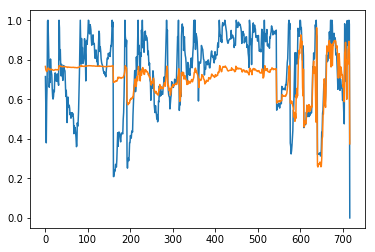

In [105]:
pred = model.predict(X_train_norm)
plt.plot(y_train_norm)
plt.plot(pred)

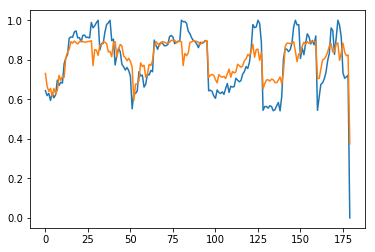

In [106]:
X_test_norm = window_normalization(X_test_prep, window_size)
y_test_norm = window_normalization(y_test_prep, window_size)

pred = model.predict(X_test_norm)
plt.plot(y_test_norm)
plt.plot(pred)